In [ ]:
#reload the modules before running the program
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy import signal
from scipy.fft import fftshift
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import math
import cv2

In [ ]:
from datasets import RFData, CameraData, SignalDataset, FuseDatasets
import metrics
import utils

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
data_path = r"D:\osa_new_processed"
# trial_folders = ["v_12_5", "v_13_5", "v_13_10"]
trial_folders = os.listdir(data_path)

# train_idxs = np.linspace(0, 49, 50, dtype=int)
train_folders = trial_folders#[trial_folders[i] for i in train_idxs]
# test_folders = [trial_folders[i] for i in range(len(trial_folders)) if i not in train_idxs]


thermal_file_name = "Thermal_Camera"
num_samps_oversample = 20 # per experiment, number of samples to generate
data_length = 9000
fs = 30
out_len = 1800 # sample length generated
thermal_ext = ".tiff"

dataset_thermal_train = CameraData(data_path, train_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)
# dataset_thermal_test = CameraData(data_path, test_folders, thermal_file_name, num_samps_oversample, fs, data_length, out_len, thermal_ext)

samp_f=5e6
freq_slope=60.012e12
samples_per_chirp=256
num_tx = 3
num_rx = 4
radar_file_name = "FMCW_Radar.npy"
window_size = 5 # number of range bins to use

dataset_radar_train = RFData(data_path, train_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)
# dataset_radar_test = RFData(data_path, test_folders, data_length, radar_file_name, out_len, window_size, samples_per_chirp, samp_f, freq_slope, num_samps_oversample, num_tx, num_rx, fs)

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
vital_dict_file_name = "gt_dict.pkl"
vital_key_radar = "CHEST"
vital_key_thermal = "AIR_flow"
l_freq_bpm = 5
u_freq_bpm = 30
dataset_OSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'OSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_CSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'CSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_MSA_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'MSA', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_hypopnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Hypopnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_partial_apnea_train = SignalDataset(data_path, train_folders, vital_dict_file_name, 'Partial_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
                              normalize=False)
dataset_gt_thermal_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
dataset_gt_radar_train = SignalDataset(data_path, train_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

# dataset_apnea_test = SignalDataset(data_path, test_folders, vital_dict_file_name, 'Sleep_Apnea', data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False,
#                               normalize=False)
# dataset_gt_thermal_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_thermal, data_length, out_len, False, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)
# dataset_gt_radar_test = SignalDataset(data_path, test_folders, vital_dict_file_name, vital_key_radar, data_length, out_len, True, fs, 1024, False, l_freq_bpm, u_freq_bpm, num_samps_oversample, False)

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
fused_dataset_train = FuseDatasets([dataset_radar_train, dataset_thermal_train, dataset_gt_radar_train, dataset_gt_thermal_train, dataset_OSA_train, dataset_CSA_train, dataset_hypopnea_train, dataset_partial_apnea_train], ["radar", "thermal", "gt_radar", "gt_ir", "gt_OSA", "gt_CSA", "hypopnea", "partial_apnea"], out_len=out_len)
# fused_dataset_test = FuseDatasets([dataset_radar_test, dataset_thermal_test, dataset_gt_radar_test, dataset_gt_thermal_test, dataset_apnea_test], ["radar", "thermal", "gt_radar", "gt_ir", "gt_apnea"], out_len=out_len)

In [ ]:
t_arr = np.linspace(0, out_len/fs, out_len)

In [120]:
vis_data_path = r"C:\Users\Adnan\Documents\OSA\figures\osa_plots"
CSA_sample = np.load(os.path.join(vis_data_path, "resp_effort_est_normal.npy"))

In [ ]:
CSA_sample = (CSA_sample - np.mean(CSA_sample)) / np.std(CSA_sample)

In [ ]:
import utils

In [130]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1
    print(len(lmin), len(lmax))
    dmax = int(2*((len(lmax))/17)**(1/2))
    dmin = dmax
    lmin = lmin[[max(i-dmin//2,0)+np.argmin(s[lmin[max(i-dmin//2,0):min(i+dmin//2,len(lmin))]]) for i in range(0,len(lmin),1)]]
    lmax = lmax[[max(i-dmax//2,0)+np.argmax(s[lmax[max(i-dmax//2,0):min(i+dmax//2,len(lmax))]]) for i in range(0,len(lmax),1)]]
    
    return lmin,lmax

In [ ]:
def predict(thermal, dmin, dmax, th, mode='max', percentage=25, interval=None, plot=False):
    """
    Input: 
    thermal: 1d-array, thermal signal
    dmin, dmax: int, optional, size of chunks
    th: float, threshold value
    mode: str, optional, mode of thresholding
    Output:
    pred: 1d-array, binary prediction
    """
    
    t_arr = np.linspace(0, len(thermal)/30, len(thermal))
    lmin, lmax = hl_envelopes_idx(thermal, dmin=dmin, dmax=dmax)
    print("lmin: ", len(lmin), "lmax: ", len(lmax), '\n')
    if(len(lmin) == 0 or len(lmax) == 0): # signal has no contrast
        return np.zeros(len(thermal))
    max_th = np.interp(t_arr, t_arr[lmax], thermal[lmax])
    min_th = np.interp(t_arr, t_arr[lmin], thermal[lmin])

    pred = None
    cn = None
    if(mode == 'max'):
        pred = ((max_th - min_th)/max(max_th - min_th) < th).astype(int)
        cn = max(max_th - min_th)
    elif(mode == '90th'):
        pred = ((max_th - min_th)/np.percentile(max_th - min_th, 90) < th).astype(int)
        cn = np.percentile(max_th - min_th, 90)
    elif(mode == 'median'):
        pred = ((max_th - min_th)/np.median(max_th - min_th) < th).astype(int)
        cn = np.median(max_th - min_th)
    elif(mode == 'mean'):
        pred = ((max_th - min_th)/np.mean(max_th - min_th) < th).astype(int)
        cn = np.mean(max_th - min_th)
    else:
        pred = ((max_th - min_th)/np.percentile(max_th - min_th, percentage) < th).astype(int)
        cn = np.percentile(max_th - min_th, percentage)
    
    if(plot == True):
        if(len(lmin) == 0 or len(lmax) == 0): # signal has no contrast
            return
        if(interval is not None):
            t_arr = t_arr + interval[0]/30
        lx = t_arr[lmin]
        mx = t_arr[lmax]

        min_env = thermal[lmin]
        max_env = thermal[lmax]
        dists_min, dists_max = utils.get_motion_scores(max_env, min_env, half_len=2)
        plt.plot(lx, min_env, 'ro-', label='low env')
        plt.plot(mx, max_env, 'go-', label='high env')
        plt.plot(t_arr, thermal, color='black', label='Thermal Video Mean Over Time')
        # plt.title("Thermal Signal with Envelope")
        # plt.ylabel("Amplitude")
        # plt.xlabel("Time (s)")
        # plt.tick_params(
        #                 axis='x',          # changes apply to the x-axis
        #                 which='both',      # both major and minor ticks are affected
        #                 bottom=False,      # ticks along the bottom edge are off
        #                 top=False,         # ticks along the top edge are off
        #                 labelbottom=False) # labels along the bottom edge are off
        # plt.tick_params(
        #                 axis='y',          # changes apply to the y-axis
        #                 which='both',      # both major and minor ticks are affected
        #                 bottom=False,      # ticks along the bottom edge are off
        #                 top=False,         # ticks along the top edge are off
        #                 labelbottom=False) # labels along the bottom edge are off
        plt.axis('off')

        # plt.legend()
        plt.show()

        plt.plot(lx, dists_min, label='low')
        plt.plot(mx, dists_max, label='high')
        plt.title("Thermal Envelope Point Distance to Neighbors")
        plt.show()

        plt.plot(t_arr, (max_th - min_th)/cn, label='Normalized Envelope Difference')
        plt.plot(t_arr, pred, label='Prediction')
        plt.title("Thermal Pred Before Thresholding")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalized Difference")
        plt.legend()
        plt.show()
    return pred

In [132]:
CSA_sample = np.load(os.path.join(vis_data_path, "thermal_est_osa.npy"))
CSA_sample = np.load(os.path.join(vis_data_path, "thermal_est_central.npy"))

In [134]:
CSA_sample = np.load(os.path.join(vis_data_path, "resp_effort_est_central.npy"))

18 17
lmin:  18 lmax:  17 



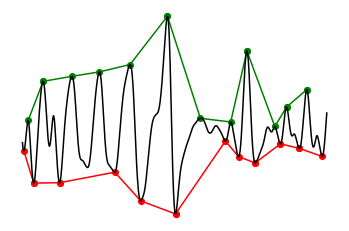

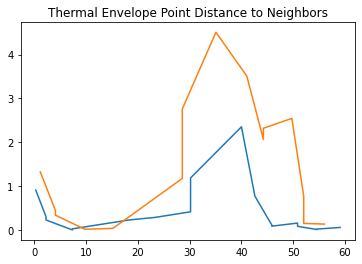

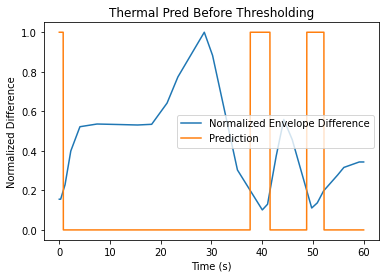

###################################################################


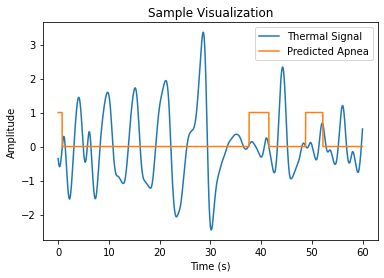

In [135]:
plot=True
thermal_th = 0.2
thermal_dmin = 2
thermal_dmax = 2

# radar_dmin = 31
# radar_dmax = 29
# movement_magnitude_th = 1 # 4.5 for thermal signal
# half_length = 90
# suppression_time_th = 150

# radar_signal = dataset_radar_train.__getitem__(idx)[:,0,0,:,2]
# if(len(radar_signal) == 1800):
    # radar_signal = radar_signal[:,0] + 1j*radar_signal[:,1]
    # radar_signal = np.unwrap(np.angle(radar_signal))
    # radar_signal = (radar_signal - np.mean(radar_signal)) / np.std(radar_signal)

# thermal_signal = utils.get_thermal(fused_dataset_train[idx])
thermal_signal = CSA_sample
thermal_signal = (thermal_signal - np.mean(thermal_signal)) / np.std(thermal_signal)

thermal_pred = predict(thermal=thermal_signal, dmin=thermal_dmin, dmax=thermal_dmax, th=thermal_th, mode='max', percentage=25, plot=plot)

print(r"###################################################################")
    # dists_min, dists_max, lmin, lmax = utils.movement_detector(radar_signal, dmin=radar_dmin, dmax=radar_dmax, plot=plot, include_edges=True)
    # center_list = utils.find_movement_peaks(dists_min, dists_max, t_arr, th=movement_magnitude_th, x_th=suppression_time_th, lmin=lmin, lmax=lmax, plot=plot)

    # signal_comps = utils.remove_peaks(center_list, radar_signal, half_length=half_length)
    # pred_rad = np.zeros(len(radar_signal))

    # for k, sig in enumerate(signal_comps):
    #     if(len(sig[0]) != 0):
    #         new_radar = (sig[0] - np.mean(sig[0]))/np.std(sig[0])
    #         # pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=int(20*((len(new_radar)/30)/30)), dmax=int(20*((len(new_radar)/30)/30)), th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=True)
    #         pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=20, dmax=20, th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=plot)

    # if(len(signal_comps) == 0):
    #     pred_rad = utils.predict(radar_signal , dmin=20, dmax=20, th=0.1, mode='max', plot=plot)
    # print('Idx: ', idx)
    # print('Iteration: ', arr_idx)
    # if(plot == False):
        # plt.plot(t_arr, radar_signal, label='Radar')
        # plt.plot(t_arr, dataset_gt_radar_train.__getitem__(idx)[:,0], label='GT Radar')
        # plt.legend()
        # plt.title('Radar')
        # plt.show()
plt.plot(t_arr, thermal_signal, label='Thermal Signal')
        # plt.plot(t_arr, (dataset_gt_thermal_train.__getitem__(idx)[:,0] - np.mean(dataset_gt_thermal_train.__getitem__(idx)[:,0])), label='GT Thermal')
plt.title('Sample Visualization')
# plt.plot(t_arr, pred_rad, linewidth=7.0, label='Predicted Radar')
# plt.plot(t_arr, 0.9*dataset_OSA_train.__getitem__(idx)[:,0], label='OSA')
# plt.plot(t_arr, 1.1*dataset_CSA_train.__getitem__(idx)[:,0], linewidth=7.0, label='CSA')
# plt.plot(t_arr, 1.5*dataset_MSA_train.__getitem__(idx)[:,0], label='MSA')
plt.plot(t_arr, thermal_pred, label='Predicted Apnea')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.legend()
plt.show()

In [ ]:
""" PSEUDO-CODE FOR ENVELOPE DETECTION ALGORITHM
1. Compute the first derivative of the signal, take the sign of the derivative
2. Compute the derivative of the sign of the derivative which is equivalent to computing the inflection points on the curve
3. Save/partition the indexes of the local minima and maxima separately as lmin and lmax
4. for each local minima in lmin, look at that local minima and the next dmin number of local minima. Replace the old local minima index with the global minima index out of these candidate lists if necessary.
5. for each local maxima in lmax, look at that local maxima and the next dmax number of local maxima. Replace the old local maxima with the global maxima out of these candidate lists if necessary.
6. return indexes
"""

In [ ]:
dataset_OSA_train.__getitem__(0)[:,0].shape

In [ ]:
OSA_idx = []
folds = []
count = 0
for i in range(len(dataset_OSA_train)):
    # print(i)
    try:
        # folds.append(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        batch = dataset_OSA_train.__getitem__(i)[:,0]
        if(np.mean(batch) > 0.1):
            OSA_idx.append(i)
    except:
        print(dataset_OSA_train.oversampling_idxs[i][0])
        # print(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        count = count + 1
        pass

print(100*len(OSA_idx)/len(dataset_OSA_train), '%')
print(count)

CSA_idx = []
count = 0
for i in range(len(dataset_CSA_train)):
    # print(i)
    try:
        # folds.append(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        batch = dataset_CSA_train.__getitem__(i)[:,0]
        if(np.mean(batch) > 0.1):
            CSA_idx.append(i)
    except:
        print(dataset_CSA_train.oversampling_idxs[i][0])
        # print(dataset_OSA_train.trial_folders[dataset_OSA_train.oversampling_idxs[i][0]])
        count = count + 1
        pass

print(100*len(CSA_idx)/len(dataset_CSA_train), '%')
print(count)

In [ ]:
import pickle
path = r"K:\OSA_project\Emir_Clean\saved_files\full_arr.pickle"
with open(path, "rb") as f:
    full_arr = pickle.load(f)

prod_arr = np.load(r"K:\OSA_project\Emir_Clean\saved_files\prod_arr.npy")

In [ ]:
best_idx = np.argsort(prod_arr)[::-1]
print(full_arr[best_idx[0]])

In [ ]:
import utils

In [ ]:
len(CSA_idx)

36, 32, 29

In [ ]:
idx = CSA_idx[29]
for arr_idx, idx in enumerate(range(len(fused_dataset_train))):
    if(r"v_30" in dataset_thermal_train.trial_folders[dataset_thermal_train.oversampling_idxs[idx][0]]):
        plot=False
        thermal_th = 0.2
        thermal_dmin = 31
        thermal_dmax = 29

        radar_dmin = 31
        radar_dmax = 29
        movement_magnitude_th = 1 # 4.5 for thermal signal
        half_length = 90
        suppression_time_th = 150

        radar_signal = dataset_radar_train.__getitem__(idx)[:,0,0,:,2]
        if(len(radar_signal) == 1800):
            radar_signal = radar_signal[:,0] + 1j*radar_signal[:,1]
            radar_signal = np.unwrap(np.angle(radar_signal))
            radar_signal = (radar_signal - np.mean(radar_signal)) / np.std(radar_signal)

            thermal_signal = utils.get_thermal(fused_dataset_train[idx])
            thermal_signal = (thermal_signal - np.mean(thermal_signal)) / np.std(thermal_signal)

            thermal_pred = utils.predict(thermal=thermal_signal, dmin=thermal_dmin, dmax=thermal_dmax, th=thermal_th, mode='max', percentage=25, plot=plot)

            print(r"###################################################################")
            dists_min, dists_max, lmin, lmax = utils.movement_detector(radar_signal, dmin=radar_dmin, dmax=radar_dmax, plot=plot, include_edges=True)
            center_list = utils.find_movement_peaks(dists_min, dists_max, t_arr, th=movement_magnitude_th, x_th=suppression_time_th, lmin=lmin, lmax=lmax, plot=plot)

            signal_comps = utils.remove_peaks(center_list, radar_signal, half_length=half_length)
            pred_rad = np.zeros(len(radar_signal))

            for k, sig in enumerate(signal_comps):
                if(len(sig[0]) != 0):
                    new_radar = (sig[0] - np.mean(sig[0]))/np.std(sig[0])
                    # pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=int(20*((len(new_radar)/30)/30)), dmax=int(20*((len(new_radar)/30)/30)), th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=True)
                    pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=20, dmax=20, th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=plot)

            if(len(signal_comps) == 0):
                pred_rad = utils.predict(radar_signal , dmin=20, dmax=20, th=0.1, mode='max', plot=plot)
            print('Idx: ', idx)
            print('Iteration: ', arr_idx)
            if(plot == False):
                plt.plot(t_arr, radar_signal, label='Radar')
                plt.plot(t_arr, dataset_gt_radar_train.__getitem__(idx)[:,0], label='GT Radar')
                plt.legend()
                plt.title('Radar')
                plt.show()
                plt.plot(t_arr, -thermal_signal, label='Thermal')
                plt.plot(t_arr, (dataset_gt_thermal_train.__getitem__(idx)[:,0] - np.mean(dataset_gt_thermal_train.__getitem__(idx)[:,0])), label='GT Thermal')
                plt.title('Thermal')
                plt.legend()
                plt.show()
            plt.plot(t_arr, pred_rad, linewidth=7.0, label='Predicted Radar')
            plt.plot(t_arr, 0.9*dataset_OSA_train.__getitem__(idx)[:,0], label='OSA')
            plt.plot(t_arr, 1.1*dataset_CSA_train.__getitem__(idx)[:,0], linewidth=7.0, label='CSA')
            plt.plot(t_arr, 1.5*dataset_MSA_train.__getitem__(idx)[:,0], label='MSA')
            plt.plot(t_arr, thermal_pred, label='Thermal Predicted')

            plt.legend()
            plt.show()

In [ ]:
vids = [1443, 1438, 1456]#864]#[3661, 3660, 3664, 3665, 3669, 3674, 3680, 3681, 3862]#2821, 2822]#3863, 3867, 3048, 2983]#[4736, 4742, 4738]

In [ ]:
len(CSA_idx), len(OSA_idx)

In [ ]:
id= 3
r"v_37" in dataset_thermal_train.trial_folders[dataset_thermal_train.oversampling_idxs[vids[id]][0]]

In [ ]:
for i in range(len(vids)):
    index = vids[i]
    image_arr = fused_dataset_train[index]["thermal"][0,:,:,:]
    # thumbnail = f"E:\OSA_project\Kai_data\{index}.png"
    # plt.imshow(image_arr[0])
    # plt.savefig(thumbnail) 
    norm_im = utils.normalize(image_arr)
    # Output video file name
    output_video = f"K:\OSA_project\{index}.mp4"
    height, width, = 64, 64
    fs = 30

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video = cv2.VideoWriter(output_video, fourcc, fs, (width, height))

    # Iterate over the image files and write each frame to the video
    for i in range(len(norm_im)):
        img = cv2.applyColorMap(norm_im[i], cv2.COLORMAP_JET)
        video.write(img)

    # Release the VideoWriter object
    video.release()


In [ ]:
radar_signal1 = dataset_radar_train.__getitem__(4702)[:,0,0,:,2]
radar_signal1 = radar_signal1[:,0] + 1j*radar_signal1[:,1]
radar_signal1 = np.unwrap(np.angle(radar_signal1))
import scipy.signal

b, a = scipy.signal.butter(2, (5/60,30/60), fs=30, btype='bandpass')
radar_signal1 = scipy.signal.filtfilt(b, a, radar_signal1)
radar_signal1 = (radar_signal1 - np.mean(radar_signal1)) / np.std(radar_signal1)
plt.plot(radar_signal1)

In [ ]:
thermal_signal1 = utils.get_thermal(fused_dataset_train[4702])
thermal_signal1 = scipy.signal.filtfilt(b,a,thermal_signal1)
thermal_signal1 = (thermal_signal1 - np.mean(thermal_signal1)) / np.std(thermal_signal1)
plt.plot(thermal_signal1)

In [ ]:
plt.plot(dataset_OSA_train.__getitem__(4702)[:,0])

In [ ]:
plt.plot(thermal_signal1)


In [ ]:

plt.plot(radar_signal1)
np.save("resp_effort_est_osa.npy", radar_signal1)



In [ ]:
idx = CSA_idx[29]
for arr_idx, idx in enumerate(OSA_idx):
    plot=False
    thermal_th = 0.2
    thermal_dmin = 31
    thermal_dmax = 29

    radar_dmin = 31
    radar_dmax = 29
    movement_magnitude_th = 1 # 4.5 for thermal signal
    half_length = 90
    suppression_time_th = 150

    radar_signal = dataset_radar_train.__getitem__(idx)[:,0,0,:,2]
    if(len(radar_signal) == 1800):
        radar_signal = radar_signal[:,0] + 1j*radar_signal[:,1]
        radar_signal = np.unwrap(np.angle(radar_signal))
        radar_signal = scipy.signal.filtfilt(b, a, radar_signal)
        radar_signal = (radar_signal - np.mean(radar_signal)) / np.std(radar_signal)

        thermal_signal = utils.get_thermal(fused_dataset_train[idx])
        thermal_signal = scipy.signal.filtfilt(b,a,thermal_signal)
        thermal_signal = (thermal_signal - np.mean(thermal_signal)) / np.std(thermal_signal)

        thermal_pred = utils.predict(thermal=thermal_signal, dmin=thermal_dmin, dmax=thermal_dmax, th=thermal_th, mode='max', percentage=25, plot=plot)

        print(r"###################################################################")
        dists_min, dists_max, lmin, lmax = utils.movement_detector(radar_signal, dmin=radar_dmin, dmax=radar_dmax, plot=plot, include_edges=True)
        center_list = utils.find_movement_peaks(dists_min, dists_max, t_arr, th=movement_magnitude_th, x_th=suppression_time_th, lmin=lmin, lmax=lmax, plot=plot)

        signal_comps = utils.remove_peaks(center_list, radar_signal, half_length=half_length)
        pred_rad = np.zeros(len(radar_signal))

        for k, sig in enumerate(signal_comps):
            if(len(sig[0]) != 0):
                new_radar = (sig[0] - np.mean(sig[0]))/np.std(sig[0])
                # pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=int(20*((len(new_radar)/30)/30)), dmax=int(20*((len(new_radar)/30)/30)), th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=True)
                pred_rad[sig[1][0]:sig[1][1]] = utils.predict(new_radar, dmin=20, dmax=20, th=0.2, mode='max', interval=[sig[1][0],sig[1][1]], plot=plot)

        if(len(signal_comps) == 0):
            pred_rad = utils.predict(radar_signal , dmin=20, dmax=20, th=0.1, mode='max', plot=plot)
        print('Idx: ', idx)
        print('Iteration: ', arr_idx)
        if(plot == False):
            plt.plot(t_arr, radar_signal, label='Radar')
            plt.plot(t_arr, scipy.signal.filtfilt(b, a, dataset_gt_radar_train.__getitem__(idx)[:,0]), label='GT Radar')
            plt.legend()
            plt.title('Radar')
            plt.show()
            plt.plot(t_arr, thermal_signal, label='Thermal')
            plt.plot(t_arr, scipy.signal.filtfilt(b, a, dataset_gt_thermal_train.__getitem__(idx)[:,0] - np.mean(dataset_gt_thermal_train.__getitem__(idx)[:,0])), label='GT Thermal')
            plt.title('Thermal')
            plt.legend()
            plt.show()
        plt.plot(t_arr, pred_rad, linewidth=7.0, label='Predicted Radar')
        plt.plot(t_arr, 0.9*dataset_OSA_train.__getitem__(idx)[:,0], label='OSA')
        plt.plot(t_arr, 1.1*dataset_CSA_train.__getitem__(idx)[:,0], linewidth=7.0, label='CSA')
        plt.plot(t_arr, 1.5*dataset_MSA_train.__getitem__(idx)[:,0], label='MSA')
        plt.plot(t_arr, thermal_pred, label='Thermal Predicted')

        plt.legend()
        plt.show()

In [ ]:
root = r"E:\OSA_project\Emir_Clean\saved_idx_arrs"
NUKS_idx = np.load(os.path.join(root, "NUKS_idx.npy"))
mode_lock_idx = np.load(os.path.join(root, "mode_lock_idx.npy"))
combined_movement_idx = np.load(os.path.join(root, "combined_movement_idx.npy"))
movement_idx = np.load(os.path.join(root, "movement_new_idx.npy"))

In [ ]:
root = r"E:\OSA_project\Emir_Clean\pre_load_data"
gt_apnea = np.load(os.path.join(root, "gt_apnea.npy"))
thermal_arr = np.load(os.path.join(root, "thermal_arr.npy"))
t_arr = np.linspace(0, 1800/30, 1800)

In [ ]:
thermal_vid_arr = np.load(os.path.join(root, "thermal_vid_arr.npy"))

In [ ]:
gt_movement_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx_arrs\gt_movement_idx.npy")
discard_idx = np.load(r"E:\OSA_project\Emir_Clean\saved_idx_arrs\discard_idx.npy")

In [ ]:
thermal_signal = fused_dataset_train['thermal'][0].shape

In [ ]:
print(precision, recall, accuracy, confusion_matrix)

In [ ]:
dmin_arr = np.linspace(15,40, 10, dtype=int)
dmax_arr = np.linspace(15,40, 10, dtype=int)
th_arr = np.linspace(1, 8, 20)

prods = []
stats = []
fps = []
for th in tqdm(th_arr):
    for dmin in tqdm(dmin_arr):
        for dmax in dmax_arr:
            gt_arr = np.zeros(1000)
            pred_arr = np.zeros(1000)
            exp_movement_idx = []
            # exp_movement_idx.extend(vid_idxs)

            for i in range(1000):
                if(i in NUKS_idx):
                    # print("NUKS")
                    pass
                elif(i in mode_lock_idx):
                    # print("Mode Lock")
                    pass
                elif(i in discard_idx):
                    # print("Discard")
                    pass
                elif(i not in vid_idxs):
                    # print("Normal")
                    if(utils.movement_detector(thermal_arr[i], dmin=dmin, dmax=dmax, th=th) == True):
                        exp_movement_idx.append(i)
            
            for i in range(1000):
                if(i in gt_movement_idx):
                    gt_arr[i] = 1
                if((i in exp_movement_idx) or (i in vid_idxs)):
                    pred_arr[i] = 1

            precision, recall, accuracy, confusion_matrix = utils.get_stats(np.array(pred_arr), np.array(gt_arr))
            prods.append(precision*recall)
            fps.append(confusion_matrix[1,0]) # want to minimize
            stats.append([precision, recall, accuracy, confusion_matrix])


In [ ]:
print(precision, recall, accuracy, confusion_matrix)

In [ ]:
# if array contains nan set that entry to zero
for i in range(len(prods)):
    if(math.isnan(prods[i])):
        prods[i] = 0

In [ ]:
best_idx = np.argsort(prods)[::-1]
best_idx = np.array(best_idx, dtype=int)

In [ ]:
id = 0
th_arr[best_idx[id] // 100], dmin_arr[(best_idx[id] % 100) // 10], dmax_arr[(best_idx[id] % 100) % 10]
# (3.3684210526315788, 40, 24)

In [ ]:
print(prods[best_idx[0]], stats[best_idx[0]])

In [ ]:
#else
print(precision, recall, accuracy, confusion_matrix)    

In [ ]:
print(precision, recall, accuracy, confusion_matrix)    

In [ ]:
for i in range(len(discard_idx)):
    index = discard_idx[i]
    image_arr = fused_dataset_train[index]["thermal"][0,:,:,:]
    # thumbnail = f"E:\OSA_project\Kai_data\{index}.png"
    # plt.imshow(image_arr[0])
    # plt.savefig(thumbnail) 
    norm_im = utils.normalize(image_arr)
    # Output video file name
    output_video = f"E:\OSA_project\{index}.mp4"
    height, width, = 64, 64
    fs = 30

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video = cv2.VideoWriter(output_video, fourcc, fs, (width, height))

    # Iterate over the image files and write each frame to the video
    for i in range(len(norm_im)):
        img = cv2.applyColorMap(norm_im[i], cv2.COLORMAP_JET)
        video.write(img)

    # Release the VideoWriter object
    video.release()


In [ ]:
for idx in range(900,1000):
    if((idx not in NUKS_idx) and (idx not in mode_lock_idx)):
        diff_arr = np.diff(thermal_vid_arr[idx], axis=0)
        mean_arr = np.std(diff_arr**2, axis=(1,2))
        pred = np.mean(utils.predict(thermal_arr[idx], 29, 31, 0.3394, plot=True)) > 0.1
        print(idx, np.std(mean_arr), pred)


        # mean_arr = mean_arr/np.std(mean_arr)
        # lmin, lmax = utils.hl_envelopes_idx(mean_arr, dmin=29, dmax=31)
        # utils.plot_envelope(t_arr[:-1], mean_arr, lmin, lmax)

        # plt.plot(t_arr[:-1] , mean_arr)
        # plt.show()
        plt.plot(t_arr, gt_apnea[idx])
        plt.show()

In [ ]:
len(movement_idx), len(combined_movement_idx)

In [ ]:
count = 0

for i in combined_movement_idx:
    if i not in movement_idx:
        count += 1

print(count)

In [ ]:
count = 0

for i in movement_idx:
    if i not in combined_movement_idx:
        count += 1

print(count)

In [ ]:
# Next steps
# 1.1 Re-run grid search for thermal, save optimal parameters and finalize stats w/o motion--> need to wait for motion filtering algorithm (IN PROGRESS)
# 1.2 create an algorithm that handles motion --> do this after finishing 1.1

# 2.1 create a function that splits indexes based on patient number for AHI metrics -->  DONE

# 3.1 make an algorithm for radar and run preliminary results --> can be done immediately

# 4.1 create an algorithm that distinguishes between central apnea and obstructive apnea --> waiting for Kai to provide data and waiting to finish radar algorithm